## Hackathon Bootcamp Python Assignment

## Assignment Overview:   

| Assignment              | Notes| 
| :---------------- | :------: | 
| Basic Assignment | Run the notebook cells step-by-step. Review the output. Modify sections that you find interesting and run it again    | 
| Recommended Challenge | Modify the Chart Output and re-run the cells. Select different variables and re-run the cells  |
| Data Science Challenge | Copy this notebook as a new .ipynb file and build your own model. Select a new sensitive variable and assess it for bias. Iterate and see if you can improve your model results    |
| Jedi Challenge | Save your final model as an astore. Create a sas file. Deploy your model into your Viya instance with proc registermodel and view it within model manager    |

Good luck! If you get lost, take a look at the [answer_key](https://github.com/sascommunities/sas-hackathon-boot-camp-2025/blob/main/workbench/assignments/answer_keys/answer_key_workbench_innovate_hackathon_python.ipynb)


#### ForestClassifier from SAS® Viya® on Customer Churn Data Set

##### About the [Churn Dataset](https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset) 

This dataset was randomly collected from an Iranian telecom company's database over a 12-month period. It comprises 3150 rows, each representing a customer, with information across 13 columns. The dataset includes attributes such as call failures, SMS frequency, number of complaints, distinct calls, subscription length, age group, charge amount, service type, usage duration, status, usage frequency, and Customer Value.

All attributes, except for the churn attribute, consist of aggregated data from the first 9 months. The churn labels indicate the customers' status at the end of the 12-month period. The three-month gap is designated for planning purposes.

### Import libraries 

In [1]:
import os
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import matplotlib.pyplot as plt

from sasviya.ml.tree import ForestClassifier
from sasviya.ml.assess import Assess
from sasviya.ml.cardinality import Cardinality

### Import customer churn data set

In [2]:
workspace=f'{os.path.abspath("")}/../../data/'
churn_df=pd.read_csv(workspace+'churn.csv')
churn_df.head(5)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


### Analyzing Cardinality

The cardinality of a variable is the number of its distinct values, and the limited cardinality of a variable is the number of its distinct values that do not exceed a specified threshold.  We can examine our input data using the Cardinality class to get a better feeling for what kind of data we're looking at.

In [3]:
card = Cardinality()

card.summarize(churn_df)

stats = card.get_summary_table()
details = card.get_details_table()

print("Cardinality summary:", stats)
print("Cardinality details:", details)

Cardinality summary:                   _VARNAME_  _FMTWIDTH_ _TYPE_  _RLEVEL_ _ORDER_ _MORE_  \
0              Call Failure        12.0      N  INTERVAL     ASC      Y   
1                 Complains        12.0      N     CLASS     ASC      N   
2       Subscription Length        12.0      N  INTERVAL     ASC      Y   
3            Charge  Amount        12.0      N     CLASS     ASC      N   
4            Seconds of Use        12.0      N  INTERVAL     ASC      Y   
5          Frequency of use        12.0      N  INTERVAL     ASC      Y   
6          Frequency of SMS        12.0      N  INTERVAL     ASC      Y   
7   Distinct Called Numbers        12.0      N  INTERVAL     ASC      Y   
8                 Age Group        12.0      N     CLASS     ASC      N   
9               Tariff Plan        12.0      N     CLASS     ASC      N   
10                   Status        12.0      N     CLASS     ASC      N   
11                      Age        12.0      N     CLASS     ASC      N   
12  

These tables are extremely useful for getting a better idea of the types and variety of the columns in our data.  We can further anlayze though!  For example, the Cardinality of Age is 5 meaning there are only five different ages in our dataset...but what are those values?  We can explore this by using Cardinalities get_levels() method, which allows us to actually see what the levels are.

In [4]:
print(card.get_levels("Age"))

['15', '25', '30', '45', '55']


It is incredibly important to understand the data you are working with, and the Cardinality class gives us those imporant insights.

### Split the data 

When training any supervised learning model, it is important to split the data into training and test data. The training data is used to fit the model. The algorithm uses the training data to learn the relationship between the features and the target. The test data is used to evaluate the performance of the model.

The code below splits the data into separate variables for the features and target, then splits into 80% training and 20% test data.

In [5]:
X_df = churn_df.drop('Churn', axis=1)
y = churn_df['Churn']  

X_train, X_test, y_train, y_test = train_test_split(X_df, y, stratify=y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2520, 13), (630, 13), (2520,), (630,))

### Fit and evaluate the forest model

First, we instantiate the Forest model with default parameters. Subsequently, we train the model using our training data by providing both the features and the target variable, enabling the model to learn.

For details about using the `ForestClassifier` class in the `sasviya` package, see the [ForestClassifier documentation](https://documentation.sas.com/?cdcId=workbenchcdc&cdcVersion=default&docsetId=explore&docsetTarget=p04zhxjh60eutqn1t40f0104gw42.htm).

In [6]:
rf = ForestClassifier(n_estimators=100, 
                      max_depth=5,
                      min_samples_leaf=1,
                      max_features=None,
                      criterion='gini',
                      random_state=0)

rf.fit(X_train, y_train)

ForestClassifier(criterion="gini", max_depth=5, min_samples_leaf=1, random_state=0)

At this stage, we have a trained Forest model; next, we need to determine if it is making accurate predictions.

In [7]:
y_pred = rf.predict_proba(X_test)

The simplest way to evaluate this model is by using accuracy.  To do this, we compare the predictions with the actual values in the test set and tally the number of correct predictions made by the model.  We can easily do this using the Assess class.  Before using the Assess class, however, we need to combine our X_test, y_test, and original churn/y values into a single dataset.

In [8]:
complete_test_data = X_test.copy(deep=True)
complete_test_data = pd.concat([complete_test_data, y_test, y_pred], axis=1)
complete_test_data

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn,P_Churn0,P_Churn1
1419,0,0,38,0,7383,129,388,46,2,1,1,25,2084.040,0,1.00,0.00
486,7,1,35,0,2265,54,59,35,3,1,2,30,328.760,1,0.22,0.78
2373,31,0,44,10,11000,109,23,50,5,1,1,55,201.135,0,1.00,0.00
3125,6,0,36,1,3145,28,7,16,3,1,1,30,154.920,0,1.00,0.00
515,0,0,37,0,5900,76,165,11,3,1,1,30,899.040,0,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,6,0,39,1,4110,78,0,27,3,1,1,30,167.520,0,1.00,0.00
2425,5,0,30,1,2885,18,7,10,3,1,1,30,144.120,0,0.98,0.02
1894,0,0,21,0,1390,26,29,13,2,1,1,25,194.220,0,1.00,0.00
2646,13,0,17,0,8638,167,59,27,5,1,1,55,220.575,0,1.00,0.00


With all the data together, we can use the Assess class to obtain our required metrics.

In [9]:
assess = Assess(
    input = "P_Churn1",
    y_true = "Churn",
    pos_label = "1",
    p_var = "P_Churn0",
    p_pos_label = "0"
)

assess.summarize(complete_test_data)

accuracy = assess.accuracy_score_
precision = assess.precision_score_
recall = assess.recall_score_

print("Accuracy:", '{:.4f}'.format(accuracy))
print("Precision:", '{:.4f}'.format(precision))
print("Recall:", '{:.4f}'.format(recall))

Accuracy: 0.9222
Precision: 0.8378
Recall: 0.6263


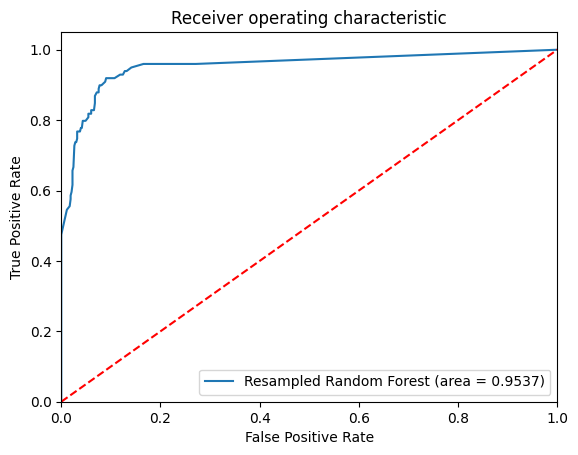

In [10]:
tpr, fpr = assess.roc_curve_
roc_auc = assess.auc_

plt.figure()
plt.plot(fpr, tpr, label='Resampled Random Forest (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

This is a commendable score! Nevertheless, we might achieve even better results by optimizing our hyperparameters.

### Hyperparameter Tuning
The code snippet below utilizes Scikit-Learn’s **RandomizedSearchCV**, which conducts a random search for parameters within specified ranges for each hyperparameter. We define the hyperparameters to be used and their respective ranges in the param_dist dictionary. In this scenario, we are utilizing:
* **n_estimators**: the number of decision trees in the forest. Increasing this hyperparameter typically enhances the model's performance, albeit at the cost of increased computational resources for training and prediction.
* **max_depth**: the maximum depth of each decision tree in the forest. Setting a higher value for max_depth can result in overfitting, while setting it too low may lead to underfitting.

In [11]:
param_dist = {'n_estimators': randint(100,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = ForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9dc096da50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9dc0972690>})

RandomizedSearchCV will train multiple models (determined by n_iter_) and save each one as variables. The code snippet below creates a variable for the best model and displays the hyperparameters. In this instance, we have not specified a scoring metric for the function, so it defaults to accuracy. Additionally, this function employs cross-validation, where the data is divided into five equally sized groups, using four for training and one for testing. It iterates through each group, providing an accuracy score that is averaged to determine the best model.

In [12]:
# Create a variable for the best modelmetrics
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 106}


### More Evaluation Metrics

First, let's get the new predictions using our best model.

In [13]:
# Generate predictions with the best model
y_pred = best_rf.predict_proba(X_test)

Next, we combine those predictions with the test dataset again.

In [14]:
complete_test_data = X_test.copy(deep=True)
complete_test_data = pd.concat([complete_test_data, y_test, y_pred], axis=1)

Lastly, we call assess on the combined dataset.

In [15]:
best_assess = Assess(
    input = "P_Churn1",
    y_true = "Churn",
    pos_label = "1",
    p_var = "P_Churn0",
    p_pos_label = "0"
)

best_assess.summarize(complete_test_data)

Assess(input="P_Churn1", y_true="Churn", pos_label="1", p_var="P_Churn0", p_pos_label="0")

Now, let's examine the confusion matrix. This matrix illustrates the model's predictions compared to the actual correct predictions. It helps us grasp the balance between false positives (top right) and false negatives (bottom left). We can visualize the confusion matrix using the following code.

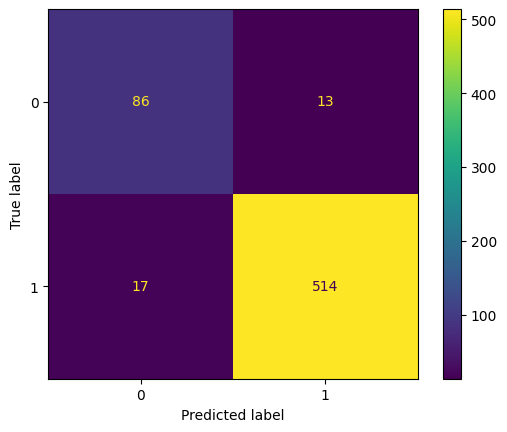

In [16]:
# Create the confusion matrix
cm = best_assess.confusion_matrix_

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

It is advisable to assess the best model using accuracy, precision, and recall. Please note that your results may vary due to randomization.

In [17]:
accuracy = best_assess.accuracy_score_
precision = best_assess.precision_score_
recall = best_assess.recall_score_

print("Accuracy:", '{:.4f}'.format(accuracy))
print("Precision:", '{:.4f}'.format(precision))
print("Recall:", '{:.4f}'.format(recall))

Accuracy: 0.9524
Precision: 0.8350
Recall: 0.8687


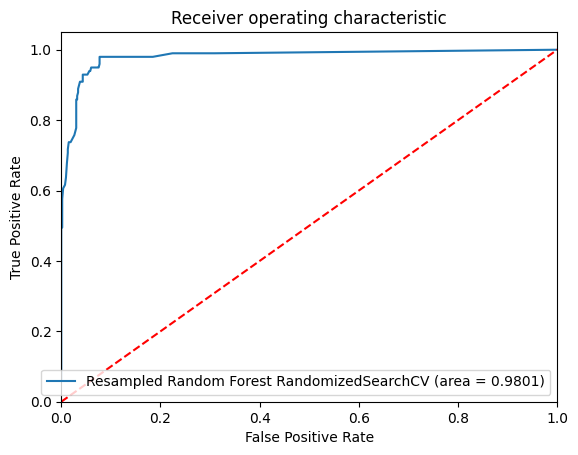

In [18]:
tpr, fpr = best_assess.roc_curve_
roc_auc = best_assess.auc_

plt.figure()
plt.plot(fpr, tpr, label='Resampled Random Forest RandomizedSearchCV (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()